# Theory
A classic example, which illustrates the working principle of Uniform pseudo-random number generators, is the **Linear Congruential Generator (LCG)** (a.k.a. multiplicative congruential generator, Lehmer generator). 

## Definition
LCG uses a recurrence relation to compute the sequence of random number realization. 
$$
\begin{align}
z_i &= az_{i-1} \hspace{5pt} \text{mod} \; m    & \\
u_i &= \frac{z_i}{m}                            & \quad i = 1,2,3,\dots
\end{align}
$$
$
\text{where} \\
\begin{array}{l l}
    \qquad a \; \& \; m &: \text{Constants integers} \\
    \qquad u_i &: \text{Realization of random number} \in [0,1) \text{ at index} \; i
\end{array}
$

Constants $(a ,\; m)$ are attributed as degree of freedom to control the performance of the generator. Usually $(a ,\; m)$ are chosen very large and mutually prime. It is good to choose m as large as possible. The following is a good choice on a $32$-bit
$$a=48271, \quad m=2^{31} −1.$$

## Examples
Let the seed $\equiv z_0= 3$, $a=48271$, and $m=2^{31} −1$. The first realization of the uniform variable would be the following:

$$
\begin{align*}
z_1 &= (48271*3) \; \text{mod} \; (2^{31} −1) = 144813 \\
&\Rightarrow \quad u_1 = \frac{144813}{2^{31} −1} = 0.000067433808 \dots
\end{align*}
$$



# Implementation
Our representation of sequence of random variable realizations will be through the use of numpy vector that holds in each row a realization

$$
\begin{bmatrix}
    u_1     \\
            \\
    \vdots  \\
            \\
    u_n     \\      
\end{bmatrix}
$$

$
\text{where} \\
\begin{array}{l l}
    \qquad u &: \text{Realization of the random variable}\\
    \qquad n &: \text{Sequence length}
\end{array}
$

## Imports

In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Parameters

In [49]:
N = 10000
seed = 1
a = 48271
m = 2**31-1

## Algorithm

```mermaid
    flowchart LR
        seed(Set seed) --> z(Compute z_i)
        z --> u(compute realization u_i)
        u --> condition{Condition?}
        condition --> |False| z
        condition --> |True| Exit[/Terminate/]
```

In [50]:
def LCG(N: int, seed: int, a: int = 48271, m: int = 2**31-1) -> np.ndarray:
    '''
    Sample uniformly distributed random variable using the pseudo-random number 
    generator Linear Congruential Generator (LCG)

    Args:
        N: Length of the sequence of realizations of the random variable
        seed: Generator seed
        a: Method param, preferably chosen large and prime
        m: Method param, preferably chosen very large and prime

    Returns:
        u: Random variable realizations
    '''
    
    z = seed
    u = np.zeros(N)

    for i in range(N):
        z_i = (a*z)%m
        u[i] = z_i/m

        # handel periodicity
        if i!= 0 and u[0] == u[i]:
            warnings.warn(f"cycle length has reached: {i}")
            return u[:i]
        
        z = z_i

    return u

## Analysis & Postprocessing
This section include visualization and performance metrics of the generated sequence of the random variable.

### Visualization
- 1D random number realizations sequence
    - Histogram: *Sequence distribution investigation*
    - CDF: *Sequence distribution investigation*
    - Q-Q Plot: *Sequence quantiles against theoretical uniform quantiles*

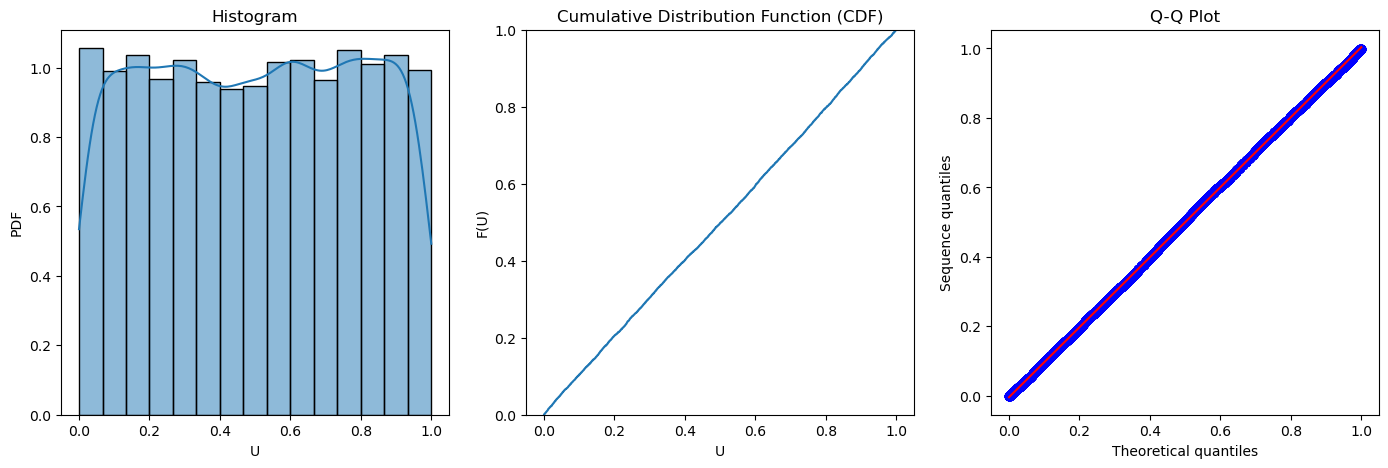

In [51]:
# generating realization sequence
u = LCG(N, seed, a, m)

fig, ax = plt.subplots(1,3, figsize=(17,5))

# histogram
sns.histplot(u, stat="density", kde=True, bins=15, ax=ax[0])
ax[0].set(xlabel="U", ylabel="PDF", title="Histogram")

# cdf
sns.ecdfplot(x=u, ax=ax[1])
ax[1].set(xlabel="U", ylabel="F(U)", title="Cumulative Distribution Function (CDF)")

# q-q plot
stats.probplot(u, dist='uniform', plot=ax[2])
ax[2].set(ylabel="Sequence quantiles", title="Q-Q Plot")

plt.show()

- 2 independent sequences of the random number realizations "this obtained by shifting the seed of the second sequence", **this investigation is used to see the behavior of the generator in higher dimensions**.
    - Scatter Plot: *Generator discrepancy analysis*

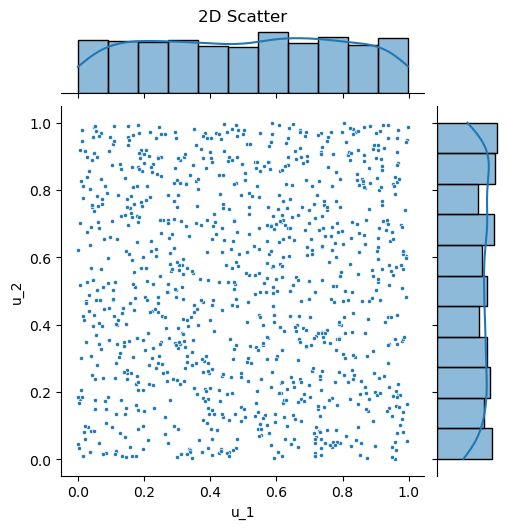

In [52]:
# generate two independent sequences
u_1 = LCG(1000, seed, a, m)
u_2 = LCG(1000, seed+2000, a, m)

# scatter
scatter = sns.jointplot(x=u_1, y=u_2, height=5, marker=".", marginal_kws={"kde": True})
scatter.ax_joint.set(xlabel="u_1", ylabel="u_2")
scatter.ax_marg_x.set(title="2D Scatter")

plt.show()

### Analysis
Analysis of the performance of the random numbers generator
- Uniformity Tests 
    - Kolmogorov-Smirnov Test: *Compare the generated sequence distribution with the reference "uniform" distribution*
    - Chi-Square Test: *Compare the generated sequence frequencies with the it average frequency being uniformly distributed*

> Both tests are based on the null hypothesis testing approach to measure the goodness-of-fit test of the generated sequence to uniform distribution. The null hypothesis assume that the generated sequence distribution **do not different** from the uniform distribution.


In [58]:
alpha = 0.05    # significance level

# kolmogorov-smirnov
ks_statistic, ks_p_value = stats.kstest(u, cdf= "uniform")

# chi-square
observed_frequencies, _ = np.histogram(u, bins=20)
average_frequency = np.sum(observed_frequencies) / len(observed_frequencies)
expected_frequencies = np.repeat([average_frequency], repeats=len(observed_frequencies))
chi_statistic, chi_p_value = stats.chisquare(observed_frequencies, expected_frequencies)

# summary
df = pd.DataFrame.from_dict(data={"Test":["kolmogorov-smirnov", "chi-square"], "Test Statistic": [ks_statistic, chi_statistic], "P-value": [ks_p_value, chi_p_value]})
df["null hypothesis"] = np.where(df['P-value'] >= alpha, "accepted", "rejected")
df["Remarks"] = np.where(df['P-value'] >= alpha, "The data is uniformly distributed", "The data is not uniformly distributed")
df

,Test,Test Statistic,P-value,null hypothesis,Remarks
0,kolmogorov-smirnov,0.006489,0.791167,accepted,The data is uniformly distributed
1,chi-square,20.748000,0.350891,accepted,The data is uniformly distributed


- Periodicity Analysis
    - Cycle Length: *Check the length of the sequence before it start repeating.*

In [59]:
def cycle_length(seed: int, a: int = 48271, m: int = 2**31-1) -> int:
    '''
    Compute the cycle length of Linear Congruential Generator (LCG) through tracing the index of
    the second occurrence of the first realization of the random number

    Args:
        seed: generator seed
        a: Method param, preferably chosen large and prime
        m: Method param, preferably chosen very large and prime

    Returns:
        cycle_length: Cycle length
    '''

    # tracing variables
    cycle_length = 0

    z = seed
    while True:
        z_i = (a*z)%m
        u_i = z_i/m

        z = z_i
        
        if cycle_length == 0:
            u_0 = u_i
        elif u_i == u_0 and cycle_length != 0:
            return cycle_length

        cycle_length = cycle_length + 1

In [60]:
# periodicity analysis
cl = cycle_length(seed, a, m)

# summary
df = pd.DataFrame.from_dict(data={"Property":["cycle length"], "Quantity": [f"{cl} realizations"]})
df

,Property,Quantity
0,cycle length,2147483646 realizations
